In [35]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
import random
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'league-of-legends-diamond-ranked-games-10-min:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F600276%2F1078419%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240129%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240129T151050Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da98751eea2540c3a2554ab4436883b7f42df40024a24bc8a858a6340904e114d62b3ffebfeebe2b96fd9dba0badea6faf0abe30c062ea90df6229d85f8ffe05232c5dc2f2bbbee7f5bb83aa9d8e73b4e19afbcc0f30d54c1ca95c0670b8a50c1d2363beb7706658b4f39ac723539bac319cda9dcf21c1d85ac4542e3da7040e587fda1a1340eb61ddd1e14bf02a2e1ec3d735090dd936bbe527046a82aa4b20c3ff0b89a597eee82629140137527ddf91829a2a79e9a41bac60f849288ab36fc1ff6e55bc9f3a4b399c2d52a58c771548c51b4aebb431c9b27e7d99dffae27f59b90ab594f973c93a2637bcdcb0fc1f1351572dce7e9cfa59313c7093ca6c972'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 552390 bytes downloaded
Downloaded and uncompressed: league-of-legends-diamond-ranked-games-10-min
Data source import complete.


In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np              # linear algebra
import pandas as pd             # data processing, I/O
import matplotlib.pyplot as plt # data visualization
import seaborn as sns           # statistical data visualization
import graphviz                 # decision tree visualization

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn import tree

# to make matplotlib graphs appears after the code
%matplotlib inline

# set random seed
random.seed(123)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


Este dataset contiene estadísticas de los objetivos importantes que influyen en una partida de League of Leyends, como muertes, asistencias, torres destruidas, oro y otros factores. Se tiene estos datos para ambos contrincantes, "azul" y "rojo", así también como el resultado del juego, si gana rojo o gana azul.

Para este laboratorio se implementarán los algoritmos de Support Vector Machine y Decision Tree para predecir la variable respuesta, "azul gana", que es 1 si gana y 0 si pierde, osea que rojo gana.

Podemos observar que tenemos 9879 observaciones, con 40 caraterísticas, siendo estas todas numéricas.

In [37]:
dataset_path = "/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv"
dataset = pd.read_csv(dataset_path)

In [38]:
dataset.shape

(9879, 40)

In [39]:
dataset.info()
dataset.apply(["min","max","mean", "median"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.20000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.00000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.20000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.36198,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.90414
median,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.00000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.80000


Debido a que tenemos datos tanto para el equipo azul como para el rojo, vamos a tomar solamente las del equipo azul y ver una correlación entre estas variables y así descartar algunas para evitar multicolinealidad.

<Axes: >

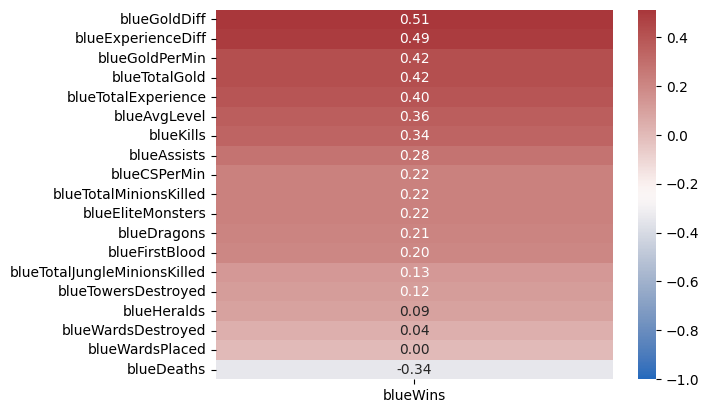

In [40]:
features = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin']

X = dataset[features]
y = dataset['blueWins']

df = X.corrwith(dataset['blueWins']).to_frame().sort_values(by=0, ascending=False)
df.columns = ['blueWins']
sns.heatmap(df, cmap='vlag', annot=True, fmt='.2f', vmin=-1)

<Axes: >

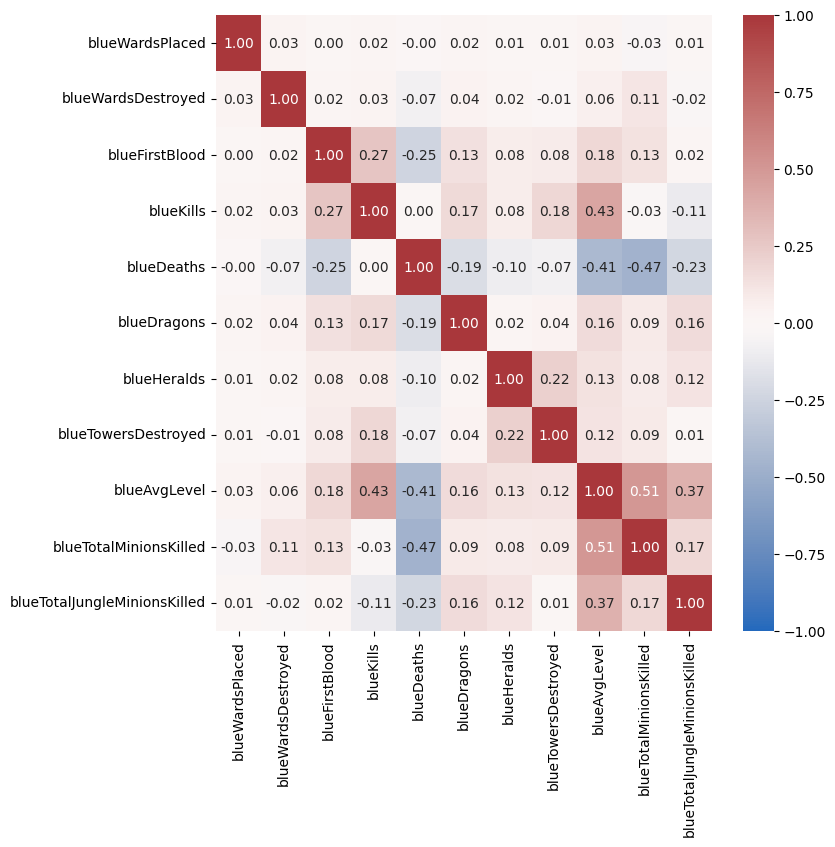

In [41]:
features = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueAvgLevel', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled']


X = dataset[features]

plt.figure(figsize=(8, 8))
sns.heatmap(X.corr(), cmap='vlag', annot=True, fmt='.2f', vmin=-1)

Así tambien, como tenemos la información del equipo rojo, vamos a obtener la diferencia entre estas estadísticas para tener una mejor generalización de las variables.

In [42]:
def get_diff(blue, red):
    diff = blue-red
    return diff

for idx, attr in enumerate(features):
  features[idx] = attr + 'Diff'
  dataset[features[idx]] = dataset.apply(lambda row: get_diff(blue = row[attr], red = row['red' + attr[4:]]), axis = 1)

dataset.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,blueWardsDestroyedDiff,blueFirstBloodDiff,blueKillsDiff,blueDeathsDiff,blueDragonsDiff,blueHeraldsDiff,blueTowersDestroyedDiff,blueAvgLevelDiff,blueTotalMinionsKilledDiff,blueTotalJungleMinionsKilledDiff
0,4519157822,0,28,2,1,9,6,11,0,0,...,-4.0,1.0,3.0,-3.0,0.0,0.0,0.0,-0.2,-2.0,-19.0
1,4523371949,0,12,1,0,5,5,5,0,0,...,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-0.2,-66.0,-9.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,-3.0,-1.0,-4.0,4.0,1.0,0.0,0.0,-0.4,-17.0,18.0
3,4524384067,0,43,1,0,4,5,5,1,0,...,-1.0,-1.0,-1.0,1.0,0.0,1.0,0.0,0.0,-34.0,8.0
4,4436033771,0,75,4,0,6,6,6,0,0,...,2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-15.0,-10.0
5,4475365709,1,18,0,0,5,3,6,1,1,...,-5.0,-1.0,2.0,-2.0,1.0,0.0,0.0,0.0,4.0,-17.0
6,4493010632,1,18,3,1,7,6,7,1,1,...,2.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.4,61.0,18.0
7,4496759358,0,16,2,0,5,13,3,0,0,...,2.0,-1.0,-8.0,8.0,-1.0,0.0,0.0,-0.2,52.0,-6.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-51.0,8.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,-1.0,1.0,-1.0,1.0,1.0,0.0,0.0,0.0,-27.0,-4.0


# TASK 3.1
Para el Support Vector Machine, vamos a utilizar una muestra de solo 1000 observaciones, debido a que el tiempo de entrenamiento es demasiado.

In [43]:
dt = dataset.sample(1000)
X = dt[features]
y = dt['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_train = [1 if x == 1 else -1 for x in y_train]
y_test = [1 if x == 1 else -1 for x in y_test]


print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (800, 11)
Test shape: (200, 11)


In [44]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, gamma=None):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.alphas = 0
        self.support_vectors = 0
        self.support_vector_labels = 0
        self.b = 0

    def _linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def _gaussian_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel == 'gaussian':
            return self._gaussian_kernel(x1, x2)
        else:
            raise ValueError("unknown kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        self.b = 0

        alpha_prev = np.copy(self.alphas)
        for i in range(n_samples):
            f_xi = self.b
            for j in range(n_samples):
                f_xi += self.alphas[j] * y[j] * self._kernel_function(X.iloc[i], X.iloc[j])
            E_i = f_xi - y[i]
            j = self._select_j(i, n_samples)
            f_xj = self.b

            for k in range(n_samples):
                f_xj += self.alphas[k] * y[k] * self._kernel_function(X.iloc[j], X.iloc[k])
            E_j = f_xj - y[j]
            eta = 2.0 * self._kernel_function(X.iloc[i], X.iloc[j]) - self._kernel_function(X.iloc[i], X.iloc[i]) - self._kernel_function(X.iloc[j], X.iloc[j])

            if eta >= 0:
                continue

            alpha_i_old = self.alphas[i]
            alpha_j_old = self.alphas[j]

            self.alphas[j] -= y[j] * (E_i - E_j) / eta
            self.alphas[j] = min(max(self.alphas[j], 0), self.C)
            self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

            b1 = self.b - E_i - y[i] * (self.alphas[i] - alpha_i_old) * self._kernel_function(X.iloc[i], X.iloc[i]) - y[j] * (self.alphas[j] - alpha_j_old) * self._kernel_function(X.iloc[i], X.iloc[j])
            b2 = self.b - E_j - y[i] * (self.alphas[i] - alpha_i_old) * self._kernel_function(X.iloc[i], X.iloc[j]) - y[j] * (self.alphas[j] - alpha_j_old) * self._kernel_function(X.iloc[j], X.iloc[j])
            self.b = (b1 + b2) / 2

        idx = self.alphas > 0
        self.support_vectors = X[idx]
        self.support_vector_labels = np.array(y)[idx]
        self.alphas = self.alphas[idx]

    def _select_j(self, i, n_samples):
        j = i
        while j == i:
            j = np.random.randint(0, n_samples)
        return j

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
          prediction = self.b
          for alpha, sv_y, sv in zip(self.alphas, self.support_vector_labels, np.array(self.support_vectors)):
            prediction += alpha * sv_y * self._kernel_function(np.array(X.iloc[i]), sv)

            y_pred[i] = np.sign(prediction)

        return y_pred


Luego de implementar el modelo, utilizaremos el kernel lineal para entrenar el modelo y hacer las predicciones, tambien se puede utilizar el kernel gaussiano y obtener otro modelo.

In [45]:
svm = SVM(kernel='linear', C=1.0, gamma=0)
svm.fit(X_train, y_train)

Luego de las predicciones, utilizamos la métrica de especificidad y sensibilidad para evaluar el desempeño, en donde nos da como resultado 66% de sensibilidad y 74% de especificidad. Ya que la especificidad tiene un mejor rendimiento, podemos decir que el modelo predice mejor cuando "rojo gana" y en menor rendimiento predice que "azul gana". Tambien podemos observar las gráficas de los grupos que se crearon y hay una similitud entre la predicción y el resultado real con un poco de esparcimiento de la variable respuesta en el otro grupo como lo muestra la sensibilidad baja.

In [46]:
predictions = svm.predict(X_test)

df = X_test
df.insert(0, "real", y_test)
df.insert(0, "prediction", predictions)

# metrica
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(sensitivity)
print(specificity)

0.6632653061224489
0.7450980392156863


<Axes: xlabel='blueKillsDiff', ylabel='blueWardsDestroyedDiff'>

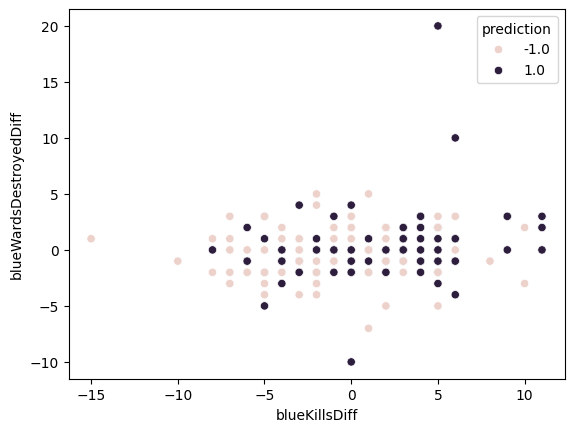

In [47]:
sns.scatterplot(data=df, x='blueKillsDiff', y='blueWardsDestroyedDiff', hue='prediction', hue_order=[1,0])

<Axes: xlabel='blueKillsDiff', ylabel='blueWardsDestroyedDiff'>

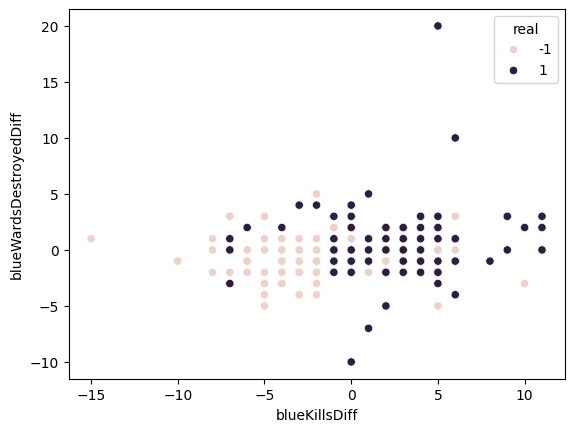

In [48]:
sns.scatterplot(data=df, x='blueKillsDiff', y='blueWardsDestroyedDiff', hue='real', hue_order=[1,0])

Después realizamos el entrenamiento y modelo de SVM con la librearía de sklearn, en donde usaremos el mismo tamaño de muestra, 1000 datos, para comparar los resultados, aunque este modelo es mucho más rápido para el entrenamiento. La métrica de rendimiento nos da como resultado 69% de sensibilidad y 80% de especificidad. De igual manera podemos observar que la especificidad fue la de mayor rendimiento en este modelo.

In [49]:
dt = dataset.sample(1000)
X = dt[features]
y = dt['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_train = [1 if x == 1 else -1 for x in y_train]
y_test = [1 if x == 1 else -1 for x in y_test]


print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")



model_svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', tol=1e-3, max_iter=-1)

model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)

sdf = X_test
sdf.insert(0, "real", y_test)
sdf.insert(0, "prediction", y_pred)
scm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(sensitivity)
print(specificity)

Train shape: (800, 11)
Test shape: (200, 11)
0.6938775510204082
0.803921568627451


# TASK 3.2
Separamos el dataset para entrenamiento y prueba, así como la variable de resultado. Luego procedemos a la implementación del algoritmo de Decision Tree y las predicciones. Se utilizara el mismo dataset pero con las observaciones completas.

In [50]:
X = dataset[features]
y = dataset['blueWins']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (7903, 11)
Test shape: (1976, 11)


In [51]:
# Partición del dataset basado en el atributo y su valor
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calcular impureza de Gini para particionar
def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Obtener la partición del dataset por clase
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Crear valor para el nodo hoja
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Crear nodo hoja y sus particiones
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check si no hay partición
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check máxima profundidad
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # nodo izquierdo
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # nodo derecho
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Función decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Print decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

  # Predicción decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Clasificación decision tree
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)


In [52]:
# Usar dataset train y test para predicciones
Xi = X_train
Xi.loc[:, "blueWins"] = y_train
Xf = X_test

preds = decision_tree(np.array(Xi), np.array(Xf), 5, 1)

Luego de hacer la predicción, se hace la métrica de rendimiento con la especificidad y la sesitividad, en donde obtenemos 67% para sensitividad y 72% para especificidad. Esto nos dice que si quisieramos apostar en quien gana la partida, tenemos mayor probabilidad de acertar al decir que rojo gana, osea verdaderos negativos que sean negativos. De igual manera, la sesitividad no tiene una diferencia mayor a 5%.

In [53]:
# métrica de rendimiento
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(sensitivity)
print(specificity)

0.6756487025948104
0.7268993839835729


Ahora con el algoritmo de Decision Tree de la librería sklearn, este nos da una menor diferencia entre especificidad y sensitividad, pero los resultados son muy similares a la implementación anterior del decision tree. Siendo la diferencia más significativa entre estos dos, es el tiempo que demora en crear el modelo, siendo sklearn mucho más rápido. En la métrica de desempeño, nos da como resultado una mejor sensitividad, por lo que es mejor prediciendo cuando "azul gana" que la negativa, "rojo gana".

In [54]:
# con librerías usamos DecisionTreeClassifier con criterio gini

X = dataset[features]
y = dataset['blueWins']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)


# fit del modelo
clf_gini.fit(X_train, y_train)

# predecir
y_pred = clf_gini.predict(X_test)

gdf = X_test
gdf.insert(0, "real", y_test)
gdf.insert(0, "prediction", y_pred)
gcm = confusion_matrix(y_test, y_pred)


# metrica
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(sensitivity)
print(specificity)

0.7397397397397397
0.6806550665301945


TASK 3.3

Ahora compararemos los mejores modelos, que son los modelos de las librerias sklearn, compararemos los grupos que realizan estos. En las gráficas se observa que si existe una similitud entre los grupos creados por ambos modelos. En esta parte, se usa todo el dataset tambíen para SVM, que toma de igual manera un tiempo considerable, Decision Tree es el modelo más rapido entre estos dos. Para seleccionar cual de estos dos usar, dependerá mucho del caso para el cual se utilice. En particular para este variable, "azul gana" conviene elegir el modelo de Decision Tree debido a su velocidad y más importante, es el que mostró mejor rendimiento en predecir correctamente la variable respuesta, "azul gana" sin muchos falsos positivos.

<Axes: xlabel='blueKillsDiff', ylabel='blueWardsDestroyedDiff'>

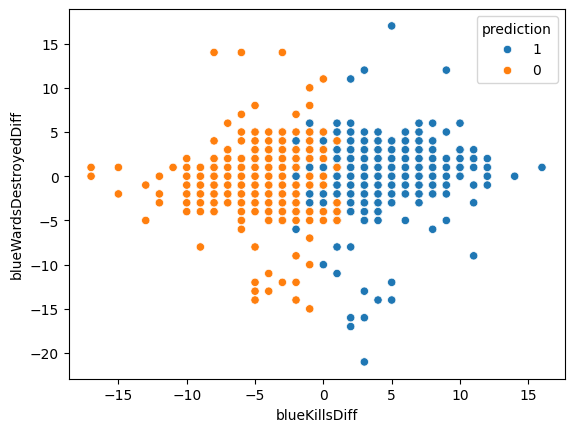

In [62]:
# svm
X = dataset[features]
y = dataset['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_train = [1 if x == 1 else -1 for x in y_train]
y_test = [1 if x == 1 else -1 for x in y_test]


model_svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', tol=1e-3, max_iter=-1)

model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)


y_pred = [1 if x == 1 else 0 for x in y_pred]

sdf = X_test
sdf.insert(0, "real", y_test)
sdf.insert(0, "prediction", y_pred)

sns.scatterplot(data=sdf, x='blueKillsDiff', y='blueWardsDestroyedDiff', hue='prediction', hue_order=[1,0])

[[758 227]
 [319 672]]


<Axes: xlabel='blueKillsDiff', ylabel='blueWardsDestroyedDiff'>

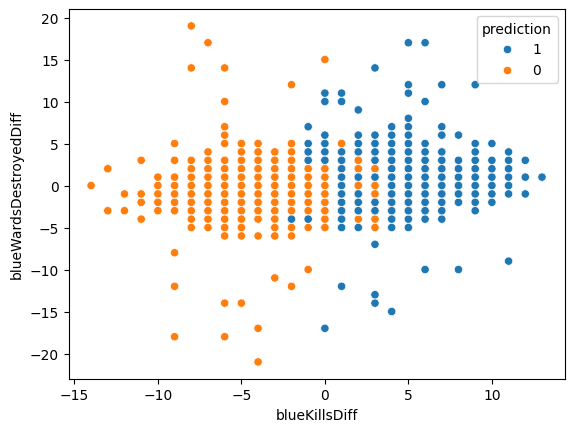

In [58]:
# dt
X = dataset[features]
y = dataset['blueWins']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)


# fit del modelo
clf_gini.fit(X_train, y_train)

# predecir
y_pred = clf_gini.predict(X_test)

gdf = X_test
gdf.insert(0, "real", y_test)
gdf.insert(0, "prediction", y_pred)


sns.scatterplot(data=gdf, x='blueKillsDiff', y='blueWardsDestroyedDiff', hue='prediction', hue_order=[1,0])

Referencias:

* https://medium.com/acuity-learning/support-vector-machines-an-explanation-with-code-44727fce3629
* https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
* https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/#How_to_Implement_SVM_in_Python_and_R?
*   https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
*   https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
*   https://www.kaggle.com/code/pragdev/leaguewinpredictor/notebook

